# Proximity Effect Analysis on External Datasets

This notebook contains all experiments relating to computing and characterizing cell proximity effects across different external datasets. It uses the spatial aging clocks to compute age acceleration for the analysis.

**Associated manuscript figures/tables:**
- Extended Data Figures: 9k
- Supplementary Table 15


**Inputs required:**
- `results/clocks/anndata/exercise_spatialsmooth.h5ad` - AnnData object for exercise data with spatial aging clock predictions (generated from `4A_application_to_interventions.ipynb`)
- `results/clocks/anndata/reprogramming_spatialsmooth.h5ad` - AnnData object for partial reprogramming data with spatial aging clock predictions (generated from `4A_application_to_interventions.ipynb`)
- `results/clocks/anndata/allen_aging_lps_spatialsmooth_spage.h5ad` - AnnData object for LPS data with spatial aging clock predictions (generated from `4A_application_to_interventions.ipynb`)
- `results/clocks/anndata/sagittal_spatialsmooth.h5ad` - AnnData object for sagittal sections data with spatial aging clock predictions (generated from `3E_clocks_external_validation.ipynb`)
- `results/clocks/anndata/androvic_injuryMERFISH_spatialsmooth_spage.h5ad` - AnnData object for demyelination injury data with spatial aging clock predictions (generated from `4A_application_to_interventions.ipynb`)
- `results/clocks/anndata/kukanja_ISSMS_spatialsmooth_spage.h5ad` - AnnData object for multiple sclerosis EAE data with spatial aging clock predictions (generated from `4A_application_to_interventions.ipynb`)
- `results/proximity/average_proximity_effect_main.csv` - proximity effects computed for coronal sections dataset (generated from `5B_cell_proximity_effect_analysis.ipynb`)

**Conda environment used**: `requirements/merfish.txt`

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import squidpy as sq
import anndata as ad
from scipy.stats import pearsonr, spearmanr, ttest_ind
import pickle
import os
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
from matplotlib.collections import PatchCollection
from matplotlib.colors import ListedColormap
import seaborn as sns
sns.set_style("ticks")
from sklearn.neighbors import BallTree

from scipy.stats import mannwhitneyu, ttest_ind
from statsmodels.stats.multitest import multipletests
from decimal import Decimal

from ageaccel_proximity import *

In [2]:
restricted_celltype_subset = ['Neuron-Excitatory','Neuron-MSN','Astrocyte','Microglia','Oligodendrocyte','OPC','Endothelial','Pericyte','VSMC','Ependymal','Neuroblast','NSC','Macrophage', 'T cell']

celltypes_full = ['Neuron-Excitatory', 'Neuron-Inhibitory', 'Neuron-MSN',
                    'Astrocyte', 'Microglia', 'Oligodendrocyte', 'OPC',
                    'Endothelial', 'Pericyte', 'VSMC', 'VLMC',
                    'Ependymal', 'Neuroblast', 'NSC', 
                    'Macrophage', 'Neutrophil','T cell', 'B cell']

# External validation: Exercise, Reprogramming, Sagittal

In [4]:
# whether to only compute for non-intervention samples
use_normal_aging_only = False

In [ ]:
#### EXERCISE

# Exercise
cutoff = {'CC/ACO': 23.57728268283302, 'CTX_L1/MEN': 22.134458488559748, 'CTX_L2/3': 21.799931867417346, 'CTX_L4/5/6': 24.813794964210643, 'STR_CP/ACB': 20.752420229228946, 'STR_LS/NDB': 19.819311916176606, 'VEN': 16.22758492467233}

adata = sc.read_h5ad("results/clocks/anndata/exercise_spatialsmooth.h5ad")

control_tag=""
if use_normal_aging_only:
    adata = adata[adata.obs.cohort.isin(["young_control","old_control"])]
    control_tag = "controlOnly"


# compute age acceleration
get_age_acceleration (adata)

# Compute nearest to cell type distances
nearest_distance_to_celltype(adata,
                             celltype_list=pd.unique(adata.obs.celltype).sort_values(),
                             sub_id="mouse_id")

# Compute proximity stats

cutoff_multiplier = 1

celltypes = ['Neuron-Excitatory', 'Neuron-Inhibitory', 'Neuron-MSN',
                    'Astrocyte', 'Microglia', 'Oligodendrocyte', 'OPC',
                    'Endothelial', 'Pericyte', 'VSMC', 'VLMC',
                    'Ependymal', 'Neuroblast', 'NSC', 
                    'Macrophage', 'Neutrophil','T cell', 'B cell']
###########################
comb_df = pd.DataFrame([])

for celltype in celltypes:
    
    for ct in pd.unique(adata.obs.celltype).sort_values():
        
        sub_adata = adata[adata.obs["celltype"]==ct]
        
        # get paired proximity sets
        near_ages = get_paired_proximity_labels(sub_adata, cutoff, celltype, cutoff_multiplier=cutoff_multiplier,)
        
        # run test
        df = get_stats_df(sub_adata, near_ages, cutoff_multiplier, celltype, ct, adata)
        
        comb_df = pd.concat((comb_df, df))
        

        
######################################

# Heatmap visualization of all proximity effects

comb_df_sub = comb_df[comb_df["AgeAccel Cell"].isin(restricted_celltype_subset)].copy()
comb_df_sub["Near Cell"] = comb_df_sub["Near Cell"].astype('category').cat.reorder_categories([x for x in celltypes_full if x in comb_df_sub['Near Cell'].values])
comb_df_sub["AgeAccel Cell"] = comb_df_sub["AgeAccel Cell"].astype('category').cat.reorder_categories([x for x in restricted_celltype_subset if x in comb_df_sub['AgeAccel Cell'].values])

pivot_df = comb_df_sub.pivot("Near Cell", "AgeAccel Cell", "Aging Effect")

fig, ax = plt.subplots(figsize=(18,10))

# set X mask for NaN values
sns.heatmap(
    np.where(pivot_df.isna(), 0, np.nan),
    square=True,
    cbar=False,
    annot=np.full_like(pivot_df, "X", dtype=object),
    fmt="",
    annot_kws={"size": 18, "va": "center_baseline", "color": "0.5"},
    cmap=ListedColormap(['none']),
    linewidth=0, ax=ax)

# make colored heatmap
sns.heatmap(pivot_df, ax=ax, square=True, cmap="RdBu_r",
            vmin=-np.nanquantile(np.abs(comb_df_sub["Aging Effect"]), 0.98),
            vmax=np.nanquantile(np.abs(comb_df_sub["Aging Effect"]), 0.98))

ax.collections[1].colorbar.set_label('Proximity Effect',
                                    rotation=270, fontsize=18, labelpad=23)
ax.collections[1].colorbar.ax.tick_params(labelsize=14)

plt.ylabel("Effector Cell Type", fontsize=18)
plt.xlabel("Target Cell Type", fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tight_layout()
plt.savefig("plots/proximity/celltype_proximity_age_accel_ttest_heatmap_ALL_spatialsmooth_regionmatchedfarthest_cohensd_EXERCISE.pdf",
          bbox_inches='tight')
plt.show()


##########################################

# subset to only restricted cells among target cell types
comb_df_sub = comb_df[comb_df["AgeAccel Cell"].isin(restricted_celltype_subset)].copy()

# compute average proximity effects for each effector cell and then rank order
celltypes = []
average_effects = []
colors = []

for ct in np.unique(comb_df_sub["Near Cell"]):
    average_effect = np.nanmean(comb_df_sub[comb_df_sub["Near Cell"]==ct]["Aging Effect"])
    if average_effect > 0:
        color = 'Pro-Aging'
    else:
        color = 'Pro-Rejuvenation'
    
    celltypes.append(ct)
    average_effects.append(average_effect)
    colors.append(color)

sort_idxs = np.argsort(average_effects)[::-1]
celltypes = np.array(celltypes)[sort_idxs]
colors = np.array(colors)[sort_idxs]
average_effects = np.array(average_effects)[sort_idxs]


palette = {"Pro-Aging":"tab:red",
           "Pro-Rejuvenation":"tab:blue"}

# generate vertical bar plot
plt.figure(figsize=(7,5))

g = sns.barplot(
    x=average_effects,
    y=celltypes,
    hue=colors,
    palette=palette,
)

plt.axvline(0, color='k', linewidth=1, linestyle="--")

plt.ylabel("Effector Cell Type", fontsize=16)
plt.xlabel("Average Proximity Effect", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14, loc="best")
plt.tight_layout()
plt.savefig("plots/proximity/celltype_proximity_age_accel_AVG_horbar_cohensd_EXERCISE.pdf",
            bbox_inches='tight')
plt.show()



# save results for later plots
save_df = pd.DataFrame([])
save_df["celltype"] = celltypes
save_df["avg_prox_eff"] = average_effects
save_df.to_csv(f"results/proximity/average_proximity_effect_EXERCISE{control_tag}.csv", index=False)

In [ ]:
### REPROGRAMMING

cutoff = {'CC/ACO': 23.64468336308264, 'CTX_L1/MEN': 20.536925931507863, 'CTX_L2/3': 21.04037750284547, 'CTX_L4/5/6': 24.05456885431489, 'STR_CP/ACB': 20.896227512408654, 'STR_LS/NDB': 20.17505733971367, 'VEN': 17.258839036280175}

adata = sc.read_h5ad("results/clocks/anndata/reprogramming_spatialsmooth.h5ad")

control_tag=""
if use_normal_aging_only:
    adata = adata[adata.obs.cohort.isin(["young_notreatment","old_notreatment"])]
    control_tag = "controlOnly"
    

# compute age acceleration
get_age_acceleration (adata)

# Compute nearest to cell type distances
nearest_distance_to_celltype(adata,
                             celltype_list=pd.unique(adata.obs.celltype).sort_values(),
                             sub_id="mouse_id")

# Compute proximity stats

cutoff_multiplier = 1

celltypes = ['Neuron-Excitatory', 'Neuron-Inhibitory', 'Neuron-MSN',
                    'Astrocyte', 'Microglia', 'Oligodendrocyte', 'OPC',
                    'Endothelial', 'Pericyte', 'VSMC', 'VLMC',
                    'Ependymal', 'Neuroblast', 'NSC', 
                    'Macrophage']
###########################
comb_df = pd.DataFrame([])

for celltype in celltypes:
    
    for ct in pd.unique(adata.obs.celltype).sort_values():
        
        sub_adata = adata[adata.obs["celltype"]==ct]
        
        # get paired proximity sets
        near_ages = get_paired_proximity_labels(sub_adata, cutoff, celltype, cutoff_multiplier=cutoff_multiplier,)
        
        # run test
        df = get_stats_df(sub_adata, near_ages, cutoff_multiplier, celltype, ct, adata)
        
        comb_df = pd.concat((comb_df, df))
        

        
######################################

# Heatmap visualization of all proximity effects

comb_df_sub = comb_df[comb_df["AgeAccel Cell"].isin(restricted_celltype_subset)].copy()
comb_df_sub["Near Cell"] = comb_df_sub["Near Cell"].astype('category').cat.reorder_categories([x for x in celltypes_full if x in comb_df_sub['Near Cell'].values])
comb_df_sub["AgeAccel Cell"] = comb_df_sub["AgeAccel Cell"].astype('category').cat.reorder_categories([x for x in restricted_celltype_subset if x in comb_df_sub['AgeAccel Cell'].values])

pivot_df = comb_df_sub.pivot("Near Cell", "AgeAccel Cell", "Aging Effect")

fig, ax = plt.subplots(figsize=(18,10))

# set X mask for NaN values
sns.heatmap(
    np.where(pivot_df.isna(), 0, np.nan),
    square=True,
    cbar=False,
    annot=np.full_like(pivot_df, "X", dtype=object),
    fmt="",
    annot_kws={"size": 18, "va": "center_baseline", "color": "0.5"},
    cmap=ListedColormap(['none']),
    linewidth=0, ax=ax)

# make colored heatmap
sns.heatmap(pivot_df, ax=ax, square=True, cmap="RdBu_r",
            vmin=-np.nanquantile(np.abs(comb_df_sub["Aging Effect"]), 0.98),
            vmax=np.nanquantile(np.abs(comb_df_sub["Aging Effect"]), 0.98))

ax.collections[1].colorbar.set_label('Proximity Effect',
                                    rotation=270, fontsize=18, labelpad=23)
ax.collections[1].colorbar.ax.tick_params(labelsize=14)

plt.ylabel("Effector Cell Type", fontsize=18)
plt.xlabel("Target Cell Type", fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tight_layout()
plt.savefig("plots/proximity/celltype_proximity_age_accel_ttest_heatmap_ALL_spatialsmooth_regionmatchedfarthest_cohensd_REPROGRAMMING.pdf",
          bbox_inches='tight')
plt.show()


##########################################

# subset to only restricted cells among target cell types
comb_df_sub = comb_df[comb_df["AgeAccel Cell"].isin(restricted_celltype_subset)].copy()

# compute average proximity effects for each effector cell and then rank order
celltypes = []
average_effects = []
colors = []

for ct in np.unique(comb_df_sub["Near Cell"]):
    average_effect = np.nanmean(comb_df_sub[comb_df_sub["Near Cell"]==ct]["Aging Effect"])
    if average_effect > 0:
        color = 'Pro-Aging'
    else:
        color = 'Pro-Rejuvenation'
    
    celltypes.append(ct)
    average_effects.append(average_effect)
    colors.append(color)

sort_idxs = np.argsort(average_effects)[::-1]
celltypes = np.array(celltypes)[sort_idxs]
colors = np.array(colors)[sort_idxs]
average_effects = np.array(average_effects)[sort_idxs]


palette = {"Pro-Aging":"tab:red",
           "Pro-Rejuvenation":"tab:blue"}

# generate vertical bar plot
plt.figure(figsize=(7,5))

g = sns.barplot(
    x=average_effects,
    y=celltypes,
    hue=colors,
    palette=palette,
)

plt.axvline(0, color='k', linewidth=1, linestyle="--")

plt.ylabel("Effector Cell Type", fontsize=16)
plt.xlabel("Average Proximity Effect", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14, loc="best")
plt.tight_layout()
plt.savefig("plots/proximity/celltype_proximity_age_accel_AVG_horbar_cohensd_REPROGRAMMING.pdf",
            bbox_inches='tight')
plt.show()

# save results for later plots
save_df = pd.DataFrame([])
save_df["celltype"] = celltypes
save_df["avg_prox_eff"] = average_effects
save_df.to_csv(f"results/proximity/average_proximity_effect_REPROGRAMMING{control_tag}.csv", index=False)

In [ ]:
### SAGITTAL

cutoff = {'CB': 15.394862470464794, 'CTX': 21.06933225056534, 'Fiber_Tracts': 25.896191542083596, 'Midbrain': 26.320422293033786, 'OB': 13.387367993709681, 'STR': 22.149953971271987, 'Thalamus': 24.36885887006188, 'VEN': 19.109962161892053}

adata = sc.read_h5ad("results/clocks/anndata/sagittal_spatialsmooth.h5ad")

# compute age acceleration
get_age_acceleration (adata)

# Compute nearest to cell type distances
nearest_distance_to_celltype(adata,
                             celltype_list=pd.unique(adata.obs.celltype).sort_values(),
                             sub_id="mouse_id")

# Compute proximity stats

cutoff_multiplier = 1

celltypes = ['Neuron-Excitatory', 'Neuron-Inhibitory', 'Neuron-MSN',
                    'Astrocyte', 'Microglia', 'Oligodendrocyte', 'OPC',
                    'Endothelial', 'Pericyte', 'VSMC', 'VLMC',
                    'Ependymal', 'Neuroblast', 'NSC', 
                    'Macrophage', 'T cell', 'B cell']
###########################
comb_df = pd.DataFrame([])

for celltype in celltypes:
    
    for ct in pd.unique(adata.obs.celltype).sort_values():
        
        sub_adata = adata[adata.obs["celltype"]==ct]
        
        # get paired proximity sets
        near_ages = get_paired_proximity_labels(sub_adata, cutoff, celltype, cutoff_multiplier=cutoff_multiplier)
        
        # run test
        df = get_stats_df(sub_adata, near_ages, cutoff_multiplier, celltype, ct, adata)
        
        comb_df = pd.concat((comb_df, df))
        

        
######################################

# Heatmap visualization of all proximity effects

comb_df_sub = comb_df[comb_df["AgeAccel Cell"].isin(restricted_celltype_subset)].copy()
comb_df_sub["Near Cell"] = comb_df_sub["Near Cell"].astype('category').cat.reorder_categories([x for x in celltypes_full if x in comb_df_sub['Near Cell'].values])
comb_df_sub["AgeAccel Cell"] = comb_df_sub["AgeAccel Cell"].astype('category').cat.reorder_categories([x for x in restricted_celltype_subset if x in comb_df_sub['AgeAccel Cell'].values])

pivot_df = comb_df_sub.pivot("Near Cell", "AgeAccel Cell", "Aging Effect")

fig, ax = plt.subplots(figsize=(18,10))

# set X mask for NaN values
sns.heatmap(
    np.where(pivot_df.isna(), 0, np.nan),
    square=True,
    cbar=False,
    annot=np.full_like(pivot_df, "X", dtype=object),
    fmt="",
    annot_kws={"size": 18, "va": "center_baseline", "color": "0.5"},
    cmap=ListedColormap(['none']),
    linewidth=0, ax=ax)

# make colored heatmap
sns.heatmap(pivot_df, ax=ax, square=True, cmap="RdBu_r",
            vmin=-np.nanquantile(np.abs(comb_df_sub["Aging Effect"]), 0.98),
            vmax=np.nanquantile(np.abs(comb_df_sub["Aging Effect"]), 0.98))

ax.collections[1].colorbar.set_label('Proximity Effect',
                                    rotation=270, fontsize=18, labelpad=23)
ax.collections[1].colorbar.ax.tick_params(labelsize=14)

plt.ylabel("Effector Cell Type", fontsize=18)
plt.xlabel("Target Cell Type", fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tight_layout()
plt.savefig("plots/proximity/celltype_proximity_age_accel_ttest_heatmap_ALL_spatialsmooth_regionmatchedfarthest_cohensd_SAGITTAL.pdf",
          bbox_inches='tight')
plt.show()


##########################################

# subset to only restricted cells among target cell types
comb_df_sub = comb_df[comb_df["AgeAccel Cell"].isin(restricted_celltype_subset)].copy()

# compute average proximity effects for each effector cell and then rank order
celltypes = []
average_effects = []
colors = []

for ct in np.unique(comb_df_sub["Near Cell"]):
    average_effect = np.nanmean(comb_df_sub[comb_df_sub["Near Cell"]==ct]["Aging Effect"])
    if average_effect > 0:
        color = 'Pro-Aging'
    else:
        color = 'Pro-Rejuvenation'
    
    celltypes.append(ct)
    average_effects.append(average_effect)
    colors.append(color)

sort_idxs = np.argsort(average_effects)[::-1]
celltypes = np.array(celltypes)[sort_idxs]
colors = np.array(colors)[sort_idxs]
average_effects = np.array(average_effects)[sort_idxs]


palette = {"Pro-Aging":"tab:red",
           "Pro-Rejuvenation":"tab:blue"}

# generate vertical bar plot
plt.figure(figsize=(7,5))

g = sns.barplot(
    x=average_effects,
    y=celltypes,
    hue=colors,
    palette=palette,
)

plt.axvline(0, color='k', linewidth=1, linestyle="--")

plt.ylabel("Effector Cell Type", fontsize=16)
plt.xlabel("Average Proximity Effect", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14, loc="best")
plt.tight_layout()
plt.savefig("plots/proximity/celltype_proximity_age_accel_AVG_horbar_cohensd_SAGITTAL.pdf",
            bbox_inches='tight')
plt.show()


# save results for later plots
save_df = pd.DataFrame([])
save_df["celltype"] = celltypes
save_df["avg_prox_eff"] = average_effects
save_df.to_csv(f"results/proximity/average_proximity_effect_SAGITTAL.csv", index=False)

# External validation: Allen et al., Androvic et al., Kukanja et al.

In [8]:
# whether to only compute for non-intervention samples
use_normal_aging_only = False

In [ ]:
### Allen et al. 2023 - allen_aging_lps_spatialsmooth_spage

cutoff = {'brain ventricle': 34.945657872703606, 'corpus callosum': 24.93541068867991, 'cortical layer II/III': 25.962599056294216, 'cortical layer V': 26.37559593552028, 'cortical layer VI': 23.691288263852037, 'olfactory region': 26.61249396836906, 'pia mater': 34.800221767412104, 'striatum': 22.51435665983618}

adata = sc.read_h5ad("results/clocks/anndata/allen_aging_lps_spatialsmooth_spage.h5ad")

control_tag=""
if use_normal_aging_only:
    adata = adata[adata.obs.cohort.isin(["aging"])]
    control_tag = "controlOnly"

# compute age acceleration
get_age_acceleration (adata)

# Compute nearest to cell type distances
nearest_distance_to_celltype(adata,
                             celltype_list=pd.unique(adata.obs.celltype).sort_values(),
                             sub_id="mouse_id")

# Compute proximity stats

cutoff_multiplier = 1

celltypes = ['Neuron-Excitatory', 'Neuron-MSN',
                    'Astrocyte', 'Microglia', 'Oligodendrocyte', 'OPC',
                    'Endothelial', 'Pericyte',  
                    'Macrophage', 'T cell']
###########################
comb_df = pd.DataFrame([])

for celltype in celltypes:
    
    for ct in pd.unique(adata.obs.celltype).sort_values():
        
        sub_adata = adata[adata.obs["celltype"]==ct]
        
        # get paired proximity sets
        near_ages = get_paired_proximity_labels(sub_adata, cutoff, celltype, cutoff_multiplier=cutoff_multiplier,)
        
        # run test
        df = get_stats_df(sub_adata, near_ages, cutoff_multiplier, celltype, ct, adata)
        
        comb_df = pd.concat((comb_df, df))
        

        
######################################

# Heatmap visualization of all proximity effects

comb_df_sub = comb_df[comb_df["AgeAccel Cell"].isin(restricted_celltype_subset)].copy()
comb_df_sub["Near Cell"] = comb_df_sub["Near Cell"].astype('category').cat.reorder_categories([x for x in celltypes_full if x in comb_df_sub['Near Cell'].values])
comb_df_sub["AgeAccel Cell"] = comb_df_sub["AgeAccel Cell"].astype('category').cat.reorder_categories([x for x in restricted_celltype_subset if x in comb_df_sub['AgeAccel Cell'].values])

pivot_df = comb_df_sub.pivot("Near Cell", "AgeAccel Cell", "Aging Effect")

fig, ax = plt.subplots(figsize=(18,10))

# set X mask for NaN values
sns.heatmap(
    np.where(pivot_df.isna(), 0, np.nan),
    square=True,
    cbar=False,
    annot=np.full_like(pivot_df, "X", dtype=object),
    fmt="",
    annot_kws={"size": 18, "va": "center_baseline", "color": "0.5"},
    cmap=ListedColormap(['none']),
    linewidth=0, ax=ax)

# make colored heatmap
sns.heatmap(pivot_df, ax=ax, square=True, cmap="RdBu_r",
            vmin=-np.nanquantile(np.abs(comb_df_sub["Aging Effect"]), 0.98),
            vmax=np.nanquantile(np.abs(comb_df_sub["Aging Effect"]), 0.98))

ax.collections[1].colorbar.set_label('Proximity Effect',
                                    rotation=270, fontsize=18, labelpad=23)
ax.collections[1].colorbar.ax.tick_params(labelsize=14)

plt.ylabel("Effector Cell Type", fontsize=18)
plt.xlabel("Target Cell Type", fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tight_layout()
plt.savefig("plots/proximity/celltype_proximity_age_accel_ttest_heatmap_ALL_spatialsmooth_regionmatchedfarthest_cohensd_ALLEN.pdf",
          bbox_inches='tight')
plt.show()


##########################################

# subset to only restricted cells among target cell types
comb_df_sub = comb_df[comb_df["AgeAccel Cell"].isin(restricted_celltype_subset)].copy()

# compute average proximity effects for each effector cell and then rank order
celltypes = []
average_effects = []
colors = []

for ct in np.unique(comb_df_sub["Near Cell"]):
    average_effect = np.nanmean(comb_df_sub[comb_df_sub["Near Cell"]==ct]["Aging Effect"])
    if average_effect > 0:
        color = 'Pro-Aging'
    else:
        color = 'Pro-Rejuvenation'
    
    celltypes.append(ct)
    average_effects.append(average_effect)
    colors.append(color)

sort_idxs = np.argsort(average_effects)[::-1]
celltypes = np.array(celltypes)[sort_idxs]
colors = np.array(colors)[sort_idxs]
average_effects = np.array(average_effects)[sort_idxs]


palette = {"Pro-Aging":"tab:red",
           "Pro-Rejuvenation":"tab:blue"}

# generate vertical bar plot
plt.figure(figsize=(7,5))

g = sns.barplot(
    x=average_effects,
    y=celltypes,
    hue=colors,
    palette=palette,
)

plt.axvline(0, color='k', linewidth=1, linestyle="--")

plt.ylabel("Effector Cell Type", fontsize=16)
plt.xlabel("Average Proximity Effect", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14, loc="best")
plt.tight_layout()
plt.savefig("plots/proximity/celltype_proximity_age_accel_AVG_horbar_cohensd_ALLEN.pdf",
            bbox_inches='tight')
plt.show()


# save results for later plots
save_df = pd.DataFrame([])
save_df["celltype"] = celltypes
save_df["avg_prox_eff"] = average_effects
save_df.to_csv(f"results/proximity/average_proximity_effect_ALLEN{control_tag}.csv", index=False)

In [ ]:
### Androvic et al. 2023 - androvic_injuryMERFISH_spatialsmooth_spage

#cutoff = {'CC/ACO': 25.996585386583547, 'CTX_L': 20.037037430176763, 'CTX_L1/MEN': 28.17350739859914, 'CTX_L2/3': 21.3979398838356, 'CTX_L4/5/6': 24.525997745306938, 'STR_CP/ACB': 23.33022187080961, 'STR_LS/NDB': 30.331776284837883, 'VEN': 24.073021790170348}
cutoff = {'CC/ACO': 26.06641612723359, 'CTX_L1/MEN': 28.17350739859914, 'CTX_L2/3': 21.3979398838356, 'CTX_L4/5/6': 24.525997745306938, 'Injury': 20.037037430176763, 'STR_CP/ACB': 23.33022187080961, 'STR_LS/NDB': 30.331776284837883, 'VEN': 23.697030476398833}

adata = sc.read_h5ad("results/clocks/anndata/androvic_injuryMERFISH_spatialsmooth_spage.h5ad")

control_tag=""
if use_normal_aging_only:
    adata = adata[adata.obs.region != "Injury"]
    control_tag = "controlOnly"

# compute age acceleration
get_age_acceleration (adata)

# Compute nearest to cell type distances
nearest_distance_to_celltype(adata,
                             celltype_list=pd.unique(adata.obs.celltype).sort_values(),
                             sub_id="mouse_id")

# Compute proximity stats

cutoff_multiplier = 1

celltypes = ['Neuron-Excitatory',
                    'Astrocyte', 'Microglia', 'Oligodendrocyte', 'OPC',
                    'Endothelial', 'Pericyte', 'VSMC', 'VLMC',
                    'Ependymal', 
                    'Macrophage', 'T cell']
###########################
comb_df = pd.DataFrame([])

for celltype in celltypes:
    
    for ct in pd.unique(adata.obs.celltype).sort_values():
        
        sub_adata = adata[adata.obs["celltype"]==ct]
        
        # get paired proximity sets
        near_ages = get_paired_proximity_labels(sub_adata, cutoff, celltype, cutoff_multiplier=cutoff_multiplier)
        
        # run test
        df = get_stats_df(sub_adata, near_ages, cutoff_multiplier, celltype, ct, adata)
        
        comb_df = pd.concat((comb_df, df))
        

        
######################################

# Heatmap visualization of all proximity effects

comb_df_sub = comb_df[comb_df["AgeAccel Cell"].isin(restricted_celltype_subset)].copy()
comb_df_sub["Near Cell"] = comb_df_sub["Near Cell"].astype('category').cat.reorder_categories([x for x in celltypes_full if x in comb_df_sub['Near Cell'].values])
comb_df_sub["AgeAccel Cell"] = comb_df_sub["AgeAccel Cell"].astype('category').cat.reorder_categories([x for x in restricted_celltype_subset if x in comb_df_sub['AgeAccel Cell'].values])

pivot_df = comb_df_sub.pivot("Near Cell", "AgeAccel Cell", "Aging Effect")

fig, ax = plt.subplots(figsize=(18,10))

# set X mask for NaN values
sns.heatmap(
    np.where(pivot_df.isna(), 0, np.nan),
    square=True,
    cbar=False,
    annot=np.full_like(pivot_df, "X", dtype=object),
    fmt="",
    annot_kws={"size": 18, "va": "center_baseline", "color": "0.5"},
    cmap=ListedColormap(['none']),
    linewidth=0, ax=ax)

# make colored heatmap
sns.heatmap(pivot_df, ax=ax, square=True, cmap="RdBu_r",
            vmin=-np.nanquantile(np.abs(comb_df_sub["Aging Effect"]), 0.98),
            vmax=np.nanquantile(np.abs(comb_df_sub["Aging Effect"]), 0.98))

ax.collections[1].colorbar.set_label('Proximity Effect',
                                    rotation=270, fontsize=18, labelpad=23)
ax.collections[1].colorbar.ax.tick_params(labelsize=14)

plt.ylabel("Effector Cell Type", fontsize=18)
plt.xlabel("Target Cell Type", fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tight_layout()
plt.savefig("plots/proximity/celltype_proximity_age_accel_ttest_heatmap_ALL_spatialsmooth_regionmatchedfarthest_cohensd_ANDROVIC.pdf",
          bbox_inches='tight')
plt.show()


##########################################

# subset to only restricted cells among target cell types
comb_df_sub = comb_df[comb_df["AgeAccel Cell"].isin(restricted_celltype_subset)].copy()

# compute average proximity effects for each effector cell and then rank order
celltypes = []
average_effects = []
colors = []

for ct in np.unique(comb_df_sub["Near Cell"]):
    average_effect = np.nanmean(comb_df_sub[comb_df_sub["Near Cell"]==ct]["Aging Effect"])
    if average_effect > 0:
        color = 'Pro-Aging'
    else:
        color = 'Pro-Rejuvenation'
    
    celltypes.append(ct)
    average_effects.append(average_effect)
    colors.append(color)

sort_idxs = np.argsort(average_effects)[::-1]
celltypes = np.array(celltypes)[sort_idxs]
colors = np.array(colors)[sort_idxs]
average_effects = np.array(average_effects)[sort_idxs]


palette = {"Pro-Aging":"tab:red",
           "Pro-Rejuvenation":"tab:blue"}

# generate vertical bar plot
plt.figure(figsize=(7,5))

g = sns.barplot(
    x=average_effects,
    y=celltypes,
    hue=colors,
    palette=palette,
)

plt.axvline(0, color='k', linewidth=1, linestyle="--")

plt.ylabel("Effector Cell Type", fontsize=16)
plt.xlabel("Average Proximity Effect", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14, loc="best")
plt.tight_layout()
plt.savefig("plots/proximity/celltype_proximity_age_accel_AVG_horbar_cohensd_ANDROVIC.pdf",
            bbox_inches='tight')
plt.show()

# save results for later plots
save_df = pd.DataFrame([])
save_df["celltype"] = celltypes
save_df["avg_prox_eff"] = average_effects
save_df.to_csv(f"results/proximity/average_proximity_effect_ANDROVIC{control_tag}.csv", index=False)

In [ ]:
### Kukanja et al. 2024 - kukanja_ISSMS_spatialsmooth_spage

restricted_celltype_subset_kukanja = ['Neuron-Excitatory','Neuron-MSN','Microglia','OPC','Pericyte','VSMC','Neuroblast','NSC','Macrophage']

cutoff = {'CC': 160.3543410056812, 'Ctx': 156.86101330978414, 'Meninges': 190.07040645993268, 'SN_HY_SI': 139.57655479131208, 'Striatum': 150.29463910644205, 'Ventricle': 115.92200524181204}

adata = sc.read_h5ad("results/clocks/anndata/kukanja_ISSMS_spatialsmooth_spage.h5ad")
region_order = ['CC', 'Ctx', 'Meninges', 'SN_HY_SI', 'Striatum', 'Ventricle']
adata = adata[adata.obs.region.isin(region_order)]

control_tag=""
if use_normal_aging_only:
    adata = adata[adata.obs.cohort.isin(["CNTRL"])]
    control_tag = "controlOnly"


# compute age acceleration
get_age_acceleration (adata)

# Compute nearest to cell type distances
nearest_distance_to_celltype(adata,
                             celltype_list=pd.unique(adata.obs.celltype).sort_values(),
                             sub_id="mouse_id")

# Compute proximity stats

cutoff_multiplier = 1

celltypes = ['Neuron-Excitatory',
              'Astrocyte', 'Microglia', 'Oligodendrocyte', 'OPC',
             'Endothelial', 'Pericyte', 'VLMC',
                    'Ependymal', 
                    'Macrophage', 'T cell']
###########################
comb_df = pd.DataFrame([])

for celltype in celltypes:
    
    for ct in pd.unique(adata.obs.celltype).sort_values():
        
        sub_adata = adata[adata.obs["celltype"]==ct]
        
        # get paired proximity sets
        near_ages = get_paired_proximity_labels(sub_adata, cutoff, celltype, cutoff_multiplier=cutoff_multiplier)
        
        # run test
        df = get_stats_df(sub_adata, near_ages, cutoff_multiplier, celltype, ct, adata)
        
        comb_df = pd.concat((comb_df, df))
        

        
######################################

# Heatmap visualization of all proximity effects

comb_df_sub = comb_df[comb_df["AgeAccel Cell"].isin(restricted_celltype_subset_kukanja)].copy()
comb_df_sub["Near Cell"] = comb_df_sub["Near Cell"].astype('category').cat.reorder_categories([x for x in celltypes_full if x in comb_df_sub['Near Cell'].values])
comb_df_sub["AgeAccel Cell"] = comb_df_sub["AgeAccel Cell"].astype('category').cat.reorder_categories([x for x in restricted_celltype_subset_kukanja if x in comb_df_sub['AgeAccel Cell'].values])

pivot_df = comb_df_sub.pivot("Near Cell", "AgeAccel Cell", "Aging Effect")

fig, ax = plt.subplots(figsize=(18,10))

# set X mask for NaN values
sns.heatmap(
    np.where(pivot_df.isna(), 0, np.nan),
    square=True,
    cbar=False,
    annot=np.full_like(pivot_df, "X", dtype=object),
    fmt="",
    annot_kws={"size": 18, "va": "center_baseline", "color": "0.5"},
    cmap=ListedColormap(['none']),
    linewidth=0, ax=ax)

# make colored heatmap
sns.heatmap(pivot_df, ax=ax, square=True, cmap="RdBu_r",
            vmin=-np.nanquantile(np.abs(comb_df_sub["Aging Effect"]), 0.98),
            vmax=np.nanquantile(np.abs(comb_df_sub["Aging Effect"]), 0.98))

ax.collections[1].colorbar.set_label('Proximity Effect',
                                    rotation=270, fontsize=18, labelpad=23)
ax.collections[1].colorbar.ax.tick_params(labelsize=14)

plt.ylabel("Effector Cell Type", fontsize=18)
plt.xlabel("Target Cell Type", fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tight_layout()
plt.savefig("plots/proximity/celltype_proximity_age_accel_ttest_heatmap_ALL_spatialsmooth_regionmatchedfarthest_cohensd_KUKANJA.pdf",
          bbox_inches='tight')
plt.show()


##########################################

# subset to only restricted cells among target cell types
comb_df_sub = comb_df[comb_df["AgeAccel Cell"].isin(restricted_celltype_subset_kukanja)].copy()

# compute average proximity effects for each effector cell and then rank order
celltypes = []
average_effects = []
colors = []

for ct in np.unique(comb_df_sub["Near Cell"]):
    average_effect = np.nanmean(comb_df_sub[comb_df_sub["Near Cell"]==ct]["Aging Effect"])
    if average_effect > 0:
        color = 'Pro-Aging'
    else:
        color = 'Pro-Rejuvenation'
    
    celltypes.append(ct)
    average_effects.append(average_effect)
    colors.append(color)

sort_idxs = np.argsort(average_effects)[::-1]
celltypes = np.array(celltypes)[sort_idxs]
colors = np.array(colors)[sort_idxs]
average_effects = np.array(average_effects)[sort_idxs]


palette = {"Pro-Aging":"tab:red",
           "Pro-Rejuvenation":"tab:blue"}

# generate vertical bar plot
plt.figure(figsize=(7,5))

g = sns.barplot(
    x=average_effects,
    y=celltypes,
    hue=colors,
    palette=palette,
)

plt.axvline(0, color='k', linewidth=1, linestyle="--")

plt.ylabel("Effector Cell Type", fontsize=16)
plt.xlabel("Average Proximity Effect", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14, loc="best")
plt.tight_layout()
plt.savefig("plots/proximity/celltype_proximity_age_accel_AVG_horbar_cohensd_KUKANJA.pdf",
            bbox_inches='tight')
plt.show()

# save results for later plots
save_df = pd.DataFrame([])
save_df["celltype"] = celltypes
save_df["avg_prox_eff"] = average_effects
save_df.to_csv(f"results/proximity/average_proximity_effect_KUKANJA{control_tag}.csv", index=False)

## External validation: Aggregate statistics

In [12]:
fn_tags = ["main", "SAGITTAL", "EXERCISE", "REPROGRAMMING",
           "ALLEN", "ANDROVIC", "KUKANJA"]

#-------------------------

# Read in all dataset proximity effects and combine into one dataframe
combined_df = []

for fnt in fn_tags:
    
    df = pd.read_csv(f"results/proximity/average_proximity_effect_{fnt}.csv")
    df["dataset"] = fnt
    
    combined_df.append(df)
    
combined_df = pd.concat(combined_df)

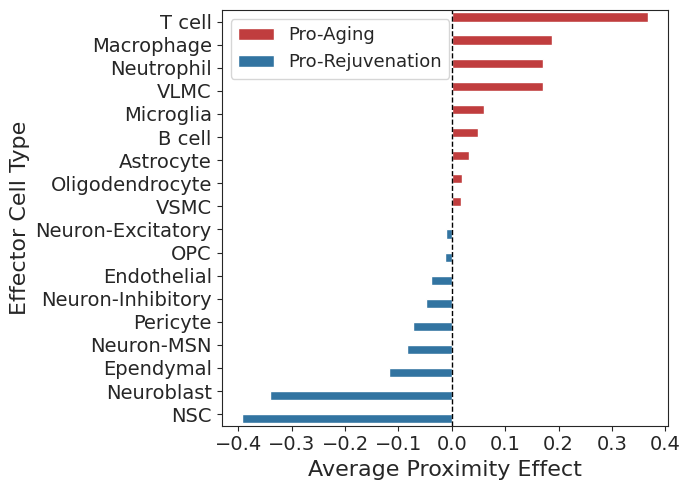

In [13]:
# Average aggregation and plot

avg_df = combined_df.groupby("celltype").mean("avg_prox_eff").sort_values("avg_prox_eff", ascending=False).reset_index()

#--------------------
colors = ["Pro-Aging" if x>0 else "Pro-Rejuvenation" for x in avg_df["avg_prox_eff"].values]

palette = {"Pro-Aging":"tab:red",
           "Pro-Rejuvenation":"tab:blue"}

# generate vertical bar plot
plt.figure(figsize=(7,5))

g = sns.barplot(
    x=avg_df["avg_prox_eff"],
    y=avg_df["celltype"],
    hue=colors,
    palette=palette,
)

plt.axvline(0, color='k', linewidth=1, linestyle="--")

plt.ylabel("Effector Cell Type", fontsize=16)
plt.xlabel("Average Proximity Effect", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=13, loc="best")
plt.tight_layout()
plt.savefig("plots/proximity/celltype_proximity_age_accel_AVG_horbar_cohensd_AVERAGE_ALL.pdf",
            bbox_inches='tight')
plt.show()

In [14]:
# Make sub dataframe with T cell and NSC information

sub_df = combined_df[combined_df['celltype'].isin(["T cell", "NSC"])]

sub_df["dataset"] = sub_df["dataset"].replace({"main":"Coronal (all sections)",
                                               "SAGITTAL":"Sagittal (all sections)",
                                               "EXERCISE":"Exercise experiment (all conditions)",
                                               "REPROGRAMMING":"Partial reprogramming experiment (all conditions)",
                                               "ALLEN":"Allen et al. (2023)",
                                               "ANDROVIC":"Androvic et al. (2023)",
                                               "KUKANJA":"Kukanja et al. (2024)"})

sub_df = sub_df.rename(columns={"celltype":"Cell type",
                       "avg_prox_eff":"Average Proximity Effect",
                       "dataset": "Dataset"})

sub_df.to_csv(f"results/proximity/average_proximity_effect_ALL_TCELL_NSC.csv", index=False)

/local/scratch/edsun/slrmtmp.42837413/ipykernel_46847/169158978.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_df["dataset"] = sub_df["dataset"].replace({"main":"Coronal (all sections)",


In [15]:
sub_df

,Cell type,Average Proximity Effect,Dataset
0,T cell,0.265618,Coronal (all sections)
17,NSC,-0.316407,Coronal (all sections)
0,T cell,0.449931,Sagittal (all sections)
16,NSC,-0.600925,Sagittal (all sections)
0,T cell,0.272657,Exercise experiment (all conditions)
17,NSC,-0.192303,Exercise experiment (all conditions)
13,NSC,-0.464755,Partial reprogramming experiment (all conditions)
0,T cell,0.230524,Allen et al. (2022)
0,T cell,0.650796,Androvic et al. (2023)
0,T cell,0.337000,Kukanja et al. (2024)


### Control samples only (run above codes with `use_normal_aging_only=True` to generate necessary files)

- Removed Kukanja due to very low numbers of T cells / NSCs in the control dataset (only 1 proximity effect pairing recovered)

In [3]:
fn_tags = ["main", "SAGITTAL", "EXERCISEcontrolOnly", "REPROGRAMMINGcontrolOnly",
           "ALLENcontrolOnly", "ANDROVICcontrolOnly"]

#-------------------------

# Read in all dataset proximity effects and combine into one dataframe
combined_df = []

for fnt in fn_tags:
    
    df = pd.read_csv(f"results/proximity/average_proximity_effect_{fnt}.csv")
    df["dataset"] = fnt
    
    combined_df.append(df)
    
combined_df = pd.concat(combined_df)

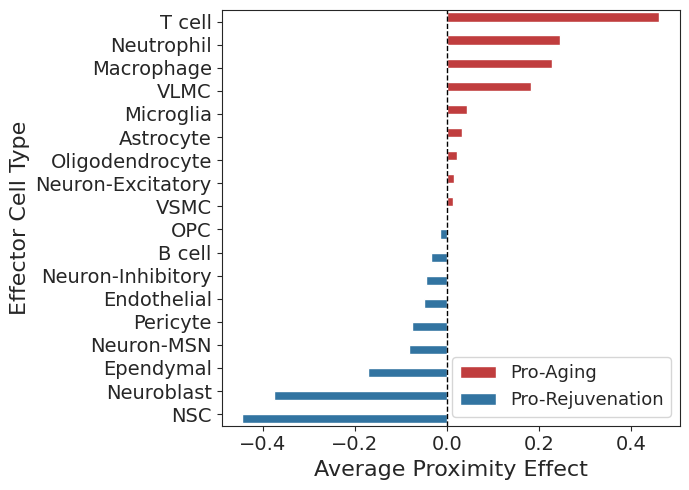

In [4]:
# Average aggregation and plot

avg_df = combined_df.groupby("celltype").mean("avg_prox_eff").sort_values("avg_prox_eff", ascending=False).reset_index()

#--------------------
colors = ["Pro-Aging" if x>0 else "Pro-Rejuvenation" for x in avg_df["avg_prox_eff"].values]

palette = {"Pro-Aging":"tab:red",
           "Pro-Rejuvenation":"tab:blue"}

# generate vertical bar plot
plt.figure(figsize=(7,5))

g = sns.barplot(
    x=avg_df["avg_prox_eff"],
    y=avg_df["celltype"],
    hue=colors,
    palette=palette,
)

plt.axvline(0, color='k', linewidth=1, linestyle="--")

plt.ylabel("Effector Cell Type", fontsize=16)
plt.xlabel("Average Proximity Effect", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=13, loc="best")
plt.tight_layout()
plt.savefig("plots/proximity/celltype_proximity_age_accel_AVG_horbar_cohensd_AVERAGE_ALL_controlOnly.pdf",
            bbox_inches='tight')
plt.show()

In [5]:
# Make sub dataframe with T cell and NSC information

sub_df = combined_df[combined_df['celltype'].isin(["T cell", "NSC"])]

sub_df["dataset"] = sub_df["dataset"].replace({"main":"Coronal (all sections)",
                                               "SAGITTAL":"Sagittal (all sections)",
                                               "EXERCISE":"Exercise experiment (all conditions)",
                                               "REPROGRAMMING":"Partial reprogramming experiment (all conditions)",
                                               "ALLEN":"Allen et al. (2023)",
                                               "ANDROVIC":"Androvic et al. (2023)"})

sub_df = sub_df.rename(columns={"celltype":"Cell type",
                       "avg_prox_eff":"Average Proximity Effect",
                       "dataset": "Dataset"})

sub_df.to_csv(f"results/proximity/average_proximity_effect_ALL_TCELL_NSC_controlOnly.csv", index=False)

/local/scratch/edsun/slrmtmp.43158897/ipykernel_8909/2130803342.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_df["dataset"] = sub_df["dataset"].replace({"main":"Coronal (all sections)",
